In [1]:
import os
import pandas as pd
path = r"C:\Users\Wong\Desktop\Dissertation\Imputed_dataset"

Morpeth_rainfall = pd.read_csv(os.path.join(path, 'Morpeth_rainfall.csv'))
Morpeth_water = pd.read_csv(os.path.join(path, 'Morpeth_water.csv'))

In [2]:
Morpeth_rainfall['dateTime'] = pd.to_datetime(Morpeth_rainfall['dateTime'])
Morpeth_water['dateTime'] = pd.to_datetime(Morpeth_water['dateTime'])

In [3]:
Morpeth_water.set_index('dateTime', inplace=True)
Morpeth_rainfall.set_index('dateTime', inplace=True)

In [4]:
start_date = pd.to_datetime('01/01/2017 00:00:00', format='%d/%m/%Y %H:%M:%S')
end_date = pd.to_datetime('31/12/2020 00:00:00', format='%d/%m/%Y %H:%M:%S')
Morpeth_water_subset = Morpeth_water.loc[(Morpeth_water.index >= start_date) & (Morpeth_water.index <= end_date)]
Morpeth_rainfall_subset = Morpeth_rainfall.loc[(Morpeth_rainfall.index >= start_date) & (Morpeth_rainfall.index <= end_date)]

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dense, Dropout

In [8]:
merged_data = pd.merge(Morpeth_rainfall_subset, Morpeth_water_subset, on='dateTime', how='inner')

In [9]:
train_merged, valid_merged, test_merged = merged_data[1:112128], merged_data[112128:126144],merged_data[126144:140161]

In [10]:
train_Morpeth = train_merged
scalers_Morpeth={}
for i in train_merged.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    transform = scaler.fit_transform(train_Morpeth[i].values.reshape(-1,1))
    transform=np.reshape(transform,len(transform))
    scalers_Morpeth['scaler_'+ i] = scaler
    train_Morpeth[i]=transform
test_Morpeth = test_merged
for i in test_merged.columns:
    scaler = scalers_Morpeth['scaler_'+i]
    transform = scaler.transform(test_Morpeth[i].values.reshape(-1,1))
    transform=np.reshape(transform,len(transform))
    scalers_Morpeth['scaler_'+i] = scaler
    test_Morpeth[i]=transform
valid_Morpeth = valid_merged
for i in valid_merged.columns:
    scaler = scalers_Morpeth['scaler_'+i]
    transform = scaler.transform(valid_Morpeth[i].values.reshape(-1,1))
    transform=np.reshape(transform,len(transform))
    scalers_Morpeth['scaler_'+i] = scaler
    valid_Morpeth[i]=transform

C:\Users\Wong\AppData\Local\Temp\ipykernel_39692\3928116605.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_Morpeth[i]=transform
C:\Users\Wong\AppData\Local\Temp\ipykernel_39692\3928116605.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_Morpeth[i]=transform
C:\Users\Wong\AppData\Local\Temp\ipykernel_39692\3928116605.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [11]:
def split(series, n_past, n_future):
    X, y = list(), list()
    for start in range(len(series)):
        p_end = start + n_past
        f_end = p_end + n_future
        if f_end > len(series):
            break
        past_window, future_window = series[start:p_end, :], series[p_end:f_end, :]
        X.append(past_window)
        y.append(future_window)
    return np.array(X), np.array(y)

In [12]:
n_past = 96
n_future = 48 
n_features = 2
X_train, y_train = split(train_Morpeth.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split(test_Morpeth.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split(valid_Morpeth.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

In [13]:
e_in = tf.keras.layers.Input(shape=(n_past, n_features))
e_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
e_outs1 = e_l1(e_in)
e_states1 = e_outs1[1:]
e_l2 = tf.keras.layers.LSTM(100, return_state=True)
e_outs2 = e_l2(e_outs1[0])
e_states2 = e_outs2[1:]

d_in = tf.keras.layers.RepeatVector(n_future)(e_outs2[0])

d_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(d_in,initial_state = e_states1)
d_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(d_l1,initial_state = e_states2)
d_outs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(d_l2)

model_e2d2_batch_32_96_in_Mor= tf.keras.models.Model(e_in,d_outs2)

In [14]:
reduce_learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2_batch_32_96_in_Mor.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2_batch_32_96_in_Mor=model_e2d2_batch_32_96_in_Mor.fit(X_train,y_train,epochs=25,validation_data=(X_valid,y_valid),batch_size=32,verbose=1,callbacks=[reduce_learning_rate])

Epoch 1/25
3500/3500 [==============================] - 745s 211ms/step - loss: 0.0013 - val_loss: 3.9443e-05 - lr: 0.0010
Epoch 2/25
3500/3500 [==============================] - 667s 191ms/step - loss: 6.2813e-04 - val_loss: 2.6964e-05 - lr: 9.0000e-04
Epoch 3/25
3500/3500 [==============================] - 668s 191ms/step - loss: 5.6191e-04 - val_loss: 1.1007e-04 - lr: 8.1000e-04
Epoch 4/25
3500/3500 [==============================] - 672s 192ms/step - loss: 5.1075e-04 - val_loss: 4.2519e-05 - lr: 7.2900e-04
Epoch 5/25
3500/3500 [==============================] - 669s 191ms/step - loss: 4.5474e-04 - val_loss: 2.2000e-04 - lr: 6.5610e-04
Epoch 6/25
3500/3500 [==============================] - 676s 193ms/step - loss: 4.1716e-04 - val_loss: 2.8723e-05 - lr: 5.9049e-04
Epoch 7/25
3500/3500 [==============================] - 671s 192ms/step - loss: 3.9434e-04 - val_loss: 3.3123e-05 - lr: 5.3144e-04
Epoch 8/25
3500/3500 [==============================] - 673s 192ms/step - loss: 3.6762e-04 

In [15]:
import pickle
with open('history_e2d2_batch_32_96_in_Mor.pkl', 'wb') as file:
    pickle.dump(history_e2d2_batch_32_96_in_Mor.history, file)

In [16]:
from keras.models import load_model
model_e2d2_batch_32_96_in_Mor.save('model_e2d2_batch_32_96_in_Mor.h5')

In [17]:
pred_e2d2_batch_32_96_in_Mor=model_e2d2_batch_32_96_in_Mor.predict(X_test)

434/434 [==============================] - 30s 66ms/step


In [18]:
for index,i in enumerate(train_merged.columns):
    scaler = scalers_Morpeth['scaler_'+i]
    pred_e2d2_batch_32_96_in_Mor[:,:,index]=scaler.inverse_transform(pred_e2d2_batch_32_96_in_Mor[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
    y_valid[:,:,index]=scaler.inverse_transform(y_valid[:,:,index])

In [19]:
def calculate_nse(y_true, y_pred):
    
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

for index, i in enumerate(train_merged.columns):
    print(i)
    for j in range(1, 49):
        print("time ", j, ":")
        mae = mean_absolute_error(y_test[:, j - 1, index], pred_e2d2_batch_32_96_in_Mor[:, j - 1, index])
        mse = mean_squared_error(y_test[:, j - 1, index], pred_e2d2_batch_32_96_in_Mor[:, j - 1, index])
        nse = calculate_nse(y_test[:, j - 1, index], pred_e2d2_batch_32_96_in_Mor[:, j - 1, index])
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("NSE: ", nse)
    print()

value_x
time  1 :
MAE:  0.05234464295797416
MSE:  0.014614707801200633
NSE:  0.21615173776532226
time  2 :
MAE:  0.0560468463657348
MSE:  0.014951603153523835
NSE:  0.19808262272959187
time  3 :
MAE:  0.053464228320960684
MSE:  0.015385258041551556
NSE:  0.1748238867347348
time  4 :
MAE:  0.05542174752657738
MSE:  0.01610953277905475
NSE:  0.13597798559905028
time  5 :
MAE:  0.05919453344297671
MSE:  0.01666690860703555
NSE:  0.10608357511083832
time  6 :
MAE:  0.06019801250196925
MSE:  0.016979373580668547
NSE:  0.08932476406082834
time  7 :
MAE:  0.05999543800266826
MSE:  0.017204529804286182
NSE:  0.07724868857476863
time  8 :
MAE:  0.05940737528152753
MSE:  0.01736038349200194
NSE:  0.06888959963911256
time  9 :
MAE:  0.05891647496064874
MSE:  0.0174178707766872
NSE:  0.06580631471723208
time  10 :
MAE:  0.05872528844314397
MSE:  0.017533392709178693
NSE:  0.059610387486582206
time  11 :
MAE:  0.0588113385596675
MSE:  0.01759888664275373
NSE:  0.05609767230143925
time  12 :
MAE:  0

In [20]:
n_past = 96
n_future = 48 
n_features = 2
X_train, y_train = split(train_Morpeth.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split(test_Morpeth.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split(valid_Morpeth.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

In [21]:
e_in = tf.keras.layers.Input(shape=(n_past, n_features))
e_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
e_outs1 = e_l1(e_in)
e_states1 = e_outs1[1:]
e_l2 = tf.keras.layers.LSTM(100, return_state=True)
e_outs2 = e_l2(e_outs1[0])
e_states2 = e_outs2[1:]

d_in = tf.keras.layers.RepeatVector(n_future)(e_outs2[0])

d_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(d_in,initial_state = e_states1)
d_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(d_l1,initial_state = e_states2)
d_outs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(d_l2)

model_e2d2_batch_64_96_in_Mor= tf.keras.models.Model(e_in,d_outs2)

In [22]:
reduce_learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2_batch_64_96_in_Mor.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2_batch_64_96_in_Mor=model_e2d2_batch_64_96_in_Mor.fit(X_train,y_train,epochs=25,validation_data=(X_valid,y_valid),batch_size=64,verbose=1,callbacks=[reduce_learning_rate])

Epoch 1/25
1750/1750 [==============================] - 572s 323ms/step - loss: 0.0017 - val_loss: 4.5826e-05 - lr: 0.0010
Epoch 2/25
1750/1750 [==============================] - 548s 313ms/step - loss: 6.6644e-04 - val_loss: 2.8361e-05 - lr: 9.0000e-04
Epoch 3/25
1750/1750 [==============================] - 551s 315ms/step - loss: 5.8584e-04 - val_loss: 4.0974e-05 - lr: 8.1000e-04
Epoch 4/25
1750/1750 [==============================] - 549s 314ms/step - loss: 5.3416e-04 - val_loss: 1.2699e-04 - lr: 7.2900e-04
Epoch 5/25
1750/1750 [==============================] - 562s 321ms/step - loss: 5.0085e-04 - val_loss: 4.5966e-05 - lr: 6.5610e-04
Epoch 6/25
1750/1750 [==============================] - 551s 315ms/step - loss: 4.6182e-04 - val_loss: 6.3555e-05 - lr: 5.9049e-04
Epoch 7/25
1750/1750 [==============================] - 554s 317ms/step - loss: 4.2991e-04 - val_loss: 2.8240e-05 - lr: 5.3144e-04
Epoch 8/25
1750/1750 [==============================] - 547s 312ms/step - loss: 4.0372e-04 

In [23]:
import pickle
with open('history_e2d2_batch_64_96_in_Mor.pkl', 'wb') as file:
    pickle.dump(history_e2d2_batch_64_96_in_Mor.history, file)

In [24]:
from keras.models import load_model
model_e2d2_batch_64_96_in_Mor.save('model_e2d2_batch_64_96_in_Mor.h5')

In [25]:
pred_e2d2_batch_64_96_in_Mor=model_e2d2_batch_64_96_in_Mor.predict(X_test)

434/434 [==============================] - 30s 66ms/step


In [26]:
for index,i in enumerate(train_merged.columns):
    scaler = scalers_Morpeth['scaler_'+i]
    pred_e2d2_batch_64_96_in_Mor[:,:,index]=scaler.inverse_transform(pred_e2d2_batch_64_96_in_Mor[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
    y_valid[:,:,index]=scaler.inverse_transform(y_valid[:,:,index])

In [27]:
def calculate_nse(y_true, y_pred):
    
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

for index, i in enumerate(train_merged.columns):
    print(i)
    for j in range(1, 49):
        print("time ", j, ":")
        mae = mean_absolute_error(y_test[:, j - 1, index], pred_e2d2_batch_64_96_in_Mor[:, j - 1, index])
        mse = mean_squared_error(y_test[:, j - 1, index], pred_e2d2_batch_64_96_in_Mor[:, j - 1, index])
        nse = calculate_nse(y_test[:, j - 1, index], pred_e2d2_batch_64_96_in_Mor[:, j - 1, index])
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("NSE: ", nse)
    print()

value_x
time  1 :
MAE:  0.05447664844854306
MSE:  0.0146841676621891
NSE:  0.21242631320867122
time  2 :
MAE:  0.057569074593188545
MSE:  0.015432396368529635
NSE:  0.172295659951892
time  3 :
MAE:  0.04681923412239199
MSE:  0.015609692307182482
NSE:  0.16278653289271916
time  4 :
MAE:  0.05549421297247464
MSE:  0.016225310514322643
NSE:  0.12976833858936132
time  5 :
MAE:  0.06057240718800242
MSE:  0.01680461702571168
NSE:  0.09869769328941036
time  6 :
MAE:  0.061630727306957685
MSE:  0.01715734546334374
NSE:  0.07977938328009715
time  7 :
MAE:  0.060555043684033576
MSE:  0.017380408002202134
NSE:  0.06781560091563243
time  8 :
MAE:  0.05909466540131027
MSE:  0.01752455823304151
NSE:  0.06008421760772342
time  9 :
MAE:  0.05786384039372056
MSE:  0.017593397204682698
NSE:  0.05639209395879652
time  10 :
MAE:  0.0569946287111121
MSE:  0.017683789707505504
NSE:  0.0515439637586923
time  11 :
MAE:  0.05637213646088448
MSE:  0.01774794427132042
NSE:  0.0481030846084014
time  12 :
MAE:  0.

In [28]:
n_past = 96
n_future = 48 
n_features = 2
X_train, y_train = split(train_Morpeth.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split(test_Morpeth.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split(valid_Morpeth.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

In [29]:
e_in = tf.keras.layers.Input(shape=(n_past, n_features))
e_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
e_outs1 = e_l1(e_in)
e_states1 = e_outs1[1:]
e_l2 = tf.keras.layers.LSTM(100, return_state=True)
e_outs2 = e_l2(e_outs1[0])
e_states2 = e_outs2[1:]

d_in = tf.keras.layers.RepeatVector(n_future)(e_outs2[0])

d_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(d_in,initial_state = e_states1)
d_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(d_l1,initial_state = e_states2)
d_outs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(d_l2)

model_e2d2_batch_128_96_in_Mor= tf.keras.models.Model(e_in,d_outs2)

In [30]:
reduce_learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2_batch_128_96_in_Mor.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2_batch_128_96_in_Mor=model_e2d2_batch_128_96_in_Mor.fit(X_train,y_train,epochs=25,validation_data=(X_valid,y_valid),batch_size=128,verbose=1,callbacks=[reduce_learning_rate])

Epoch 1/25
875/875 [==============================] - 457s 515ms/step - loss: 0.0023 - val_loss: 1.9660e-04 - lr: 0.0010
Epoch 2/25
875/875 [==============================] - 450s 515ms/step - loss: 6.9282e-04 - val_loss: 1.5922e-04 - lr: 9.0000e-04
Epoch 3/25
875/875 [==============================] - 446s 509ms/step - loss: 6.4171e-04 - val_loss: 3.6731e-05 - lr: 8.1000e-04
Epoch 4/25
875/875 [==============================] - 479s 548ms/step - loss: 5.7883e-04 - val_loss: 6.5556e-05 - lr: 7.2900e-04
Epoch 5/25
875/875 [==============================] - 449s 513ms/step - loss: 5.4286e-04 - val_loss: 2.0451e-04 - lr: 6.5610e-04
Epoch 6/25
875/875 [==============================] - 435s 497ms/step - loss: 5.3143e-04 - val_loss: 5.5982e-05 - lr: 5.9049e-04
Epoch 7/25
875/875 [==============================] - 435s 498ms/step - loss: 4.8406e-04 - val_loss: 3.8424e-05 - lr: 5.3144e-04
Epoch 8/25
875/875 [==============================] - 438s 501ms/step - loss: 4.5662e-04 - val_loss: 5.18

In [31]:
import pickle
with open('history_e2d2_batch_128_96_in_Mor.pkl', 'wb') as file:
    pickle.dump(history_e2d2_batch_128_96_in_Mor.history, file)

In [32]:
from keras.models import load_model
model_e2d2_batch_128_96_in_Mor.save('model_e2d2_batch_128_96_in_Mor.h5')

In [33]:
pred_e2d2_batch_128_96_in_Mor=model_e2d2_batch_128_96_in_Mor.predict(X_test)

434/434 [==============================] - 30s 67ms/step


In [34]:
for index,i in enumerate(train_merged.columns):
    scaler = scalers_Morpeth['scaler_'+i]
    pred_e2d2_batch_128_96_in_Mor[:,:,index]=scaler.inverse_transform(pred_e2d2_batch_128_96_in_Mor[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
    y_valid[:,:,index]=scaler.inverse_transform(y_valid[:,:,index])

In [35]:
def calculate_nse(y_true, y_pred):
    
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

for index, i in enumerate(train_merged.columns):
    print(i)
    for j in range(1, 49):
        print("time ", j, ":")
        mae = mean_absolute_error(y_test[:, j - 1, index], pred_e2d2_batch_128_96_in_Mor[:, j - 1, index])
        mse = mean_squared_error(y_test[:, j - 1, index], pred_e2d2_batch_128_96_in_Mor[:, j - 1, index])
        nse = calculate_nse(y_test[:, j - 1, index], pred_e2d2_batch_128_96_in_Mor[:, j - 1, index])
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("NSE: ", nse)
    print()

value_x
time  1 :
MAE:  0.047543864253819075
MSE:  0.01464225109775717
NSE:  0.21467447489864477
time  2 :
MAE:  0.04233069375811455
MSE:  0.014941050813426242
NSE:  0.19864858912184002
time  3 :
MAE:  0.03679001247492146
MSE:  0.01579955327869266
NSE:  0.15260349026136288
time  4 :
MAE:  0.039300628954473026
MSE:  0.016588928170499825
NSE:  0.11026599397943926
time  5 :
MAE:  0.04314399948096146
MSE:  0.017271425524606497
NSE:  0.07366078966927636
time  6 :
MAE:  0.04370273466421811
MSE:  0.01767054114625155
NSE:  0.05225453983433359
time  7 :
MAE:  0.04278697934359533
MSE:  0.017923242015279218
NSE:  0.03870112913690882
time  8 :
MAE:  0.0421725405975297
MSE:  0.018140507252800125
NSE:  0.027048280431936633
time  9 :
MAE:  0.04231094439046869
MSE:  0.01836225914331578
NSE:  0.015154793651881215
time  10 :
MAE:  0.04299560634733712
MSE:  0.01861269653336736
NSE:  0.0017227828542114576
time  11 :
MAE:  0.043865943631686964
MSE:  0.018855139149842427
NSE:  -0.011280434603204936
time  12

Now try different batch size for 48input

In [36]:
n_past = 48
n_future = 48 
n_features = 2
X_train, y_train = split(train_Morpeth.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split(test_Morpeth.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split(valid_Morpeth.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

In [37]:
e_in = tf.keras.layers.Input(shape=(n_past, n_features))
e_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
e_outs1 = e_l1(e_in)
e_states1 = e_outs1[1:]
e_l2 = tf.keras.layers.LSTM(100, return_state=True)
e_outs2 = e_l2(e_outs1[0])
e_states2 = e_outs2[1:]

d_in = tf.keras.layers.RepeatVector(n_future)(e_outs2[0])

d_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(d_in,initial_state = e_states1)
d_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(d_l1,initial_state = e_states2)
d_outs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(d_l2)

model_e2d2_batch_32_48_in_Mor= tf.keras.models.Model(e_in,d_outs2)

In [38]:
reduce_learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2_batch_32_48_in_Mor.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2_batch_32_48_in_Mor=model_e2d2_batch_32_48_in_Mor.fit(X_train,y_train,epochs=25,validation_data=(X_valid,y_valid),batch_size=32,verbose=1,callbacks=[reduce_learning_rate])

Epoch 1/25
3501/3501 [==============================] - 446s 126ms/step - loss: 0.0013 - val_loss: 3.8167e-05 - lr: 0.0010
Epoch 2/25
3501/3501 [==============================] - 438s 125ms/step - loss: 6.2215e-04 - val_loss: 5.6988e-04 - lr: 9.0000e-04
Epoch 3/25
3501/3501 [==============================] - 442s 126ms/step - loss: 5.4632e-04 - val_loss: 5.1934e-05 - lr: 8.1000e-04
Epoch 4/25
3501/3501 [==============================] - 437s 125ms/step - loss: 4.9544e-04 - val_loss: 5.3947e-05 - lr: 7.2900e-04
Epoch 5/25
3501/3501 [==============================] - 434s 124ms/step - loss: 4.3857e-04 - val_loss: 4.3801e-05 - lr: 6.5610e-04
Epoch 6/25
3501/3501 [==============================] - 434s 124ms/step - loss: 4.2028e-04 - val_loss: 3.4822e-05 - lr: 5.9049e-04
Epoch 7/25
3501/3501 [==============================] - 435s 124ms/step - loss: 4.0171e-04 - val_loss: 2.8827e-05 - lr: 5.3144e-04
Epoch 8/25
3501/3501 [==============================] - 434s 124ms/step - loss: 3.7195e-04 

In [39]:
import pickle
with open('history_e2d2_batch_32_48_in_Mor.pkl', 'wb') as file:
    pickle.dump(history_e2d2_batch_32_48_in_Mor.history, file)

In [40]:
from keras.models import load_model
model_e2d2_batch_32_48_in_Mor.save('model_e2d2_batch_32_48_in_Mor.h5')

In [41]:
pred_e2d2_batch_32_48_in_Mor=model_e2d2_batch_32_48_in_Mor.predict(X_test)

436/436 [==============================] - 21s 44ms/step


In [42]:
for index,i in enumerate(train_merged.columns):
    scaler = scalers_Morpeth['scaler_'+i]
    pred_e2d2_batch_32_48_in_Mor[:,:,index]=scaler.inverse_transform(pred_e2d2_batch_32_48_in_Mor[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
    y_valid[:,:,index]=scaler.inverse_transform(y_valid[:,:,index])

In [43]:
def calculate_nse(y_true, y_pred):
    
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

for index, i in enumerate(train_merged.columns):
    print(i)
    for j in range(1, 49):
        print("time ", j, ":")
        mae = mean_absolute_error(y_test[:, j - 1, index], pred_e2d2_batch_32_48_in_Mor[:, j - 1, index])
        mse = mean_squared_error(y_test[:, j - 1, index], pred_e2d2_batch_32_48_in_Mor[:, j - 1, index])
        nse = calculate_nse(y_test[:, j - 1, index], pred_e2d2_batch_32_48_in_Mor[:, j - 1, index])
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("NSE: ", nse)
    print()

value_x
time  1 :
MAE:  0.04259361086215996
MSE:  0.013691413286024549
NSE:  0.2632397745785513
time  2 :
MAE:  0.044154617190417016
MSE:  0.014828625151086851
NSE:  0.20204430464773848
time  3 :
MAE:  0.042692345410835594
MSE:  0.015779945031167593
NSE:  0.15085202561459954
time  4 :
MAE:  0.0405884596388529
MSE:  0.015844906222611498
NSE:  0.1473563439744351
time  5 :
MAE:  0.04022301902486504
MSE:  0.016268913575547075
NSE:  0.12453972552876724
time  6 :
MAE:  0.04227223497290594
MSE:  0.016623838996615587
NSE:  0.10544053337296877
time  7 :
MAE:  0.04309121927432527
MSE:  0.016945052119967396
NSE:  0.08815546219550507
time  8 :
MAE:  0.0439512585831834
MSE:  0.017229594691798276
NSE:  0.07284370109498317
time  9 :
MAE:  0.04453831115867979
MSE:  0.017365891093809063
NSE:  0.06550934007820608
time  10 :
MAE:  0.04482820606842354
MSE:  0.01750432142410254
NSE:  0.05806014844097096
time  11 :
MAE:  0.04481924301264543
MSE:  0.01757134174072029
NSE:  0.054453661473733206
time  12 :
MAE

In [44]:
n_past = 48
n_future = 48 
n_features = 2
X_train, y_train = split(train_Morpeth.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split(test_Morpeth.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split(valid_Morpeth.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

In [45]:
e_in = tf.keras.layers.Input(shape=(n_past, n_features))
e_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
e_outs1 = e_l1(e_in)
e_states1 = e_outs1[1:]
e_l2 = tf.keras.layers.LSTM(100, return_state=True)
e_outs2 = e_l2(e_outs1[0])
e_states2 = e_outs2[1:]

d_in = tf.keras.layers.RepeatVector(n_future)(e_outs2[0])

d_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(d_in,initial_state = e_states1)
d_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(d_l1,initial_state = e_states2)
d_outs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(d_l2)

model_e2d2_batch_64_48_in_Mor= tf.keras.models.Model(e_in,d_outs2)

In [46]:
reduce_learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2_batch_64_48_in_Mor.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2_batch_64_48_in_Mor=model_e2d2_batch_64_48_in_Mor.fit(X_train,y_train,epochs=25,validation_data=(X_valid,y_valid),batch_size=64,verbose=1,callbacks=[reduce_learning_rate])

Epoch 1/25
1751/1751 [==============================] - 374s 210ms/step - loss: 0.0017 - val_loss: 4.7088e-05 - lr: 0.0010
Epoch 2/25
1751/1751 [==============================] - 387s 221ms/step - loss: 6.6915e-04 - val_loss: 1.6348e-04 - lr: 9.0000e-04
Epoch 3/25
1751/1751 [==============================] - 383s 219ms/step - loss: 5.9467e-04 - val_loss: 3.4892e-05 - lr: 8.1000e-04
Epoch 4/25
1751/1751 [==============================] - 382s 218ms/step - loss: 5.3637e-04 - val_loss: 2.7623e-05 - lr: 7.2900e-04
Epoch 5/25
1751/1751 [==============================] - 382s 218ms/step - loss: 4.9222e-04 - val_loss: 2.7530e-04 - lr: 6.5610e-04
Epoch 6/25
1751/1751 [==============================] - 382s 218ms/step - loss: 4.9008e-04 - val_loss: 4.1389e-05 - lr: 5.9049e-04
Epoch 7/25
1751/1751 [==============================] - 388s 222ms/step - loss: 4.3611e-04 - val_loss: 4.1361e-05 - lr: 5.3144e-04
Epoch 8/25
1751/1751 [==============================] - 383s 219ms/step - loss: 4.2616e-04 

In [47]:
import pickle
with open('history_e2d2_batch_64_48_in_Mor.pkl', 'wb') as file:
    pickle.dump(history_e2d2_batch_64_48_in_Mor.history, file)

In [48]:
from keras.models import load_model
model_e2d2_batch_64_48_in_Mor.save('model_e2d2_batch_64_48_in_Mor.h5')

In [49]:
pred_e2d2_batch_64_48_in_Mor=model_e2d2_batch_64_48_in_Mor.predict(X_test)

436/436 [==============================] - 29s 62ms/step


In [50]:
for index,i in enumerate(train_merged.columns):
    scaler = scalers_Morpeth['scaler_'+i]
    pred_e2d2_batch_64_48_in_Mor[:,:,index]=scaler.inverse_transform(pred_e2d2_batch_64_48_in_Mor[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
    y_valid[:,:,index]=scaler.inverse_transform(y_valid[:,:,index])

In [51]:
def calculate_nse(y_true, y_pred):
    
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

for index, i in enumerate(train_merged.columns):
    print(i)
    for j in range(1, 49):
        print("time ", j, ":")
        mae = mean_absolute_error(y_test[:, j - 1, index], pred_e2d2_batch_64_48_in_Mor[:, j - 1, index])
        mse = mean_squared_error(y_test[:, j - 1, index], pred_e2d2_batch_64_48_in_Mor[:, j - 1, index])
        nse = calculate_nse(y_test[:, j - 1, index], pred_e2d2_batch_64_48_in_Mor[:, j - 1, index])
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("NSE: ", nse)
    print()

value_x
time  1 :
MAE:  0.05807188791580284
MSE:  0.015692649328668748
NSE:  0.15554956852764734
time  2 :
MAE:  0.05541441160107299
MSE:  0.016065040883529842
NSE:  0.13551049146724214
time  3 :
MAE:  0.0480298248665315
MSE:  0.015580115425881183
NSE:  0.16160522559191481
time  4 :
MAE:  0.04677450968021707
MSE:  0.016019628469316524
NSE:  0.1379542173145134
time  5 :
MAE:  0.048725755459287756
MSE:  0.016480626889128675
NSE:  0.11314704126889474
time  6 :
MAE:  0.04978075395228453
MSE:  0.016784674065742067
NSE:  0.0967857013764607
time  7 :
MAE:  0.050162373785247884
MSE:  0.017043701792425574
NSE:  0.08284694119773273
time  8 :
MAE:  0.04985658559633128
MSE:  0.017263007112410113
NSE:  0.07104571705728124
time  9 :
MAE:  0.04912354787568302
MSE:  0.017369804146439558
NSE:  0.0652987714920491
time  10 :
MAE:  0.048440087899520014
MSE:  0.017524970302975583
NSE:  0.05694899414773724
time  11 :
MAE:  0.047957727967055865
MSE:  0.01763473060511377
NSE:  0.05104258965491504
time  12 :
M

In [52]:
n_past = 48
n_future = 48 
n_features = 2
X_train, y_train = split(train_Morpeth.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split(test_Morpeth.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split(valid_Morpeth.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

In [53]:
e_in = tf.keras.layers.Input(shape=(n_past, n_features))
e_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
e_outs1 = e_l1(e_in)
e_states1 = e_outs1[1:]
e_l2 = tf.keras.layers.LSTM(100, return_state=True)
e_outs2 = e_l2(e_outs1[0])
e_states2 = e_outs2[1:]

d_in = tf.keras.layers.RepeatVector(n_future)(e_outs2[0])

d_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(d_in,initial_state = e_states1)
d_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(d_l1,initial_state = e_states2)
d_outs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(d_l2)

model_e2d2_batch_128_48_in_Mor= tf.keras.models.Model(e_in,d_outs2)

In [54]:
reduce_learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2_batch_128_48_in_Mor.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2_batch_128_48_in_Mor=model_e2d2_batch_128_48_in_Mor.fit(X_train,y_train,epochs=25,validation_data=(X_valid,y_valid),batch_size=128,verbose=1,callbacks=[reduce_learning_rate])

Epoch 1/25
876/876 [==============================] - 326s 360ms/step - loss: 0.0027 - val_loss: 7.8964e-05 - lr: 0.0010
Epoch 2/25
876/876 [==============================] - 324s 370ms/step - loss: 7.0488e-04 - val_loss: 7.8111e-05 - lr: 9.0000e-04
Epoch 3/25
876/876 [==============================] - 338s 386ms/step - loss: 6.3469e-04 - val_loss: 6.7245e-05 - lr: 8.1000e-04
Epoch 4/25
876/876 [==============================] - 359s 410ms/step - loss: 5.9229e-04 - val_loss: 4.3798e-05 - lr: 7.2900e-04
Epoch 5/25
876/876 [==============================] - 342s 390ms/step - loss: 5.4751e-04 - val_loss: 3.7230e-05 - lr: 6.5610e-04
Epoch 6/25
876/876 [==============================] - 337s 385ms/step - loss: 5.2161e-04 - val_loss: 5.1698e-05 - lr: 5.9049e-04
Epoch 7/25
876/876 [==============================] - 337s 385ms/step - loss: 5.0273e-04 - val_loss: 9.3302e-05 - lr: 5.3144e-04
Epoch 8/25
876/876 [==============================] - 337s 384ms/step - loss: 4.7337e-04 - val_loss: 6.43

In [55]:
import pickle
with open('history_e2d2_batch_128_48_in_Mor.pkl', 'wb') as file:
    pickle.dump(history_e2d2_batch_128_48_in_Mor.history, file)

In [56]:
from keras.models import load_model
model_e2d2_batch_128_48_in_Mor.save('model_e2d2_batch_128_48_in_Mor.h5')

In [57]:
pred_e2d2_batch_128_48_in_Mor=model_e2d2_batch_128_48_in_Mor.predict(X_test)

436/436 [==============================] - 24s 52ms/step


In [58]:
for index,i in enumerate(train_merged.columns):
    scaler = scalers_Morpeth['scaler_'+i]
    pred_e2d2_batch_128_48_in_Mor[:,:,index]=scaler.inverse_transform(pred_e2d2_batch_128_48_in_Mor[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
    y_valid[:,:,index]=scaler.inverse_transform(y_valid[:,:,index])

In [59]:
def calculate_nse(y_true, y_pred):
    
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

for index, i in enumerate(train_merged.columns):
    print(i)
    for j in range(1, 49):
        print("time ", j, ":")
        mae = mean_absolute_error(y_test[:, j - 1, index], pred_e2d2_batch_128_48_in_Mor[:, j - 1, index])
        mse = mean_squared_error(y_test[:, j - 1, index], pred_e2d2_batch_128_48_in_Mor[:, j - 1, index])
        nse = calculate_nse(y_test[:, j - 1, index], pred_e2d2_batch_128_48_in_Mor[:, j - 1, index])
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("NSE: ", nse)
    print()

value_x
time  1 :
MAE:  0.05761969520074524
MSE:  0.016471696723304268
NSE:  0.11362758997839573
time  2 :
MAE:  0.050676121192921454
MSE:  0.016635796435557258
NSE:  0.10479708150820621
time  3 :
MAE:  0.04616354288788793
MSE:  0.01662887767191775
NSE:  0.10516939295277294
time  4 :
MAE:  0.036808722990669715
MSE:  0.016288099527036772
NSE:  0.12350729405882521
time  5 :
MAE:  0.03478466262665038
MSE:  0.016423753384360692
NSE:  0.11620750955788717
time  6 :
MAE:  0.03540609126453267
MSE:  0.01673901520892653
NSE:  0.09924268875512965
time  7 :
MAE:  0.03593271707552433
MSE:  0.017074308595523797
NSE:  0.08119993261804914
time  8 :
MAE:  0.0364346200300077
MSE:  0.017344108693650943
NSE:  0.06668149124444844
time  9 :
MAE:  0.03712919128955447
MSE:  0.017523172026060296
NSE:  0.0570457627484503
time  10 :
MAE:  0.03800638134625448
MSE:  0.017657002085171184
NSE:  0.04984412019637374
time  11 :
MAE:  0.03892918707249067
MSE:  0.017743538488992384
NSE:  0.04518743654695445
time  12 :
MA

now try different batch size for 24 input

In [60]:
n_past = 24
n_future = 48 
n_features = 2
X_train, y_train = split(train_Morpeth.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split(test_Morpeth.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split(valid_Morpeth.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

In [61]:
e_in = tf.keras.layers.Input(shape=(n_past, n_features))
e_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
e_outs1 = e_l1(e_in)
e_states1 = e_outs1[1:]
e_l2 = tf.keras.layers.LSTM(100, return_state=True)
e_outs2 = e_l2(e_outs1[0])
e_states2 = e_outs2[1:]

d_in = tf.keras.layers.RepeatVector(n_future)(e_outs2[0])

d_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(d_in,initial_state = e_states1)
d_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(d_l1,initial_state = e_states2)
d_outs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(d_l2)

model_e2d2_batch_32_24_in_Mor= tf.keras.models.Model(e_in,d_outs2)

In [62]:
reduce_learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2_batch_32_24_in_Mor.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2_batch_32_24_in_Mor=model_e2d2_batch_32_24_in_Mor.fit(X_train,y_train,epochs=25,validation_data=(X_valid,y_valid),batch_size=32,verbose=1,callbacks=[reduce_learning_rate])

Epoch 1/25
3502/3502 [==============================] - 468s 132ms/step - loss: 0.0013 - val_loss: 2.0873e-04 - lr: 0.0010
Epoch 2/25
3502/3502 [==============================] - 452s 129ms/step - loss: 6.4034e-04 - val_loss: 1.3523e-04 - lr: 9.0000e-04
Epoch 3/25
3502/3502 [==============================] - 447s 128ms/step - loss: 5.7865e-04 - val_loss: 2.9878e-04 - lr: 8.1000e-04
Epoch 4/25
3502/3502 [==============================] - 448s 128ms/step - loss: 5.2250e-04 - val_loss: 4.8493e-05 - lr: 7.2900e-04
Epoch 5/25
3502/3502 [==============================] - 447s 128ms/step - loss: 4.8649e-04 - val_loss: 3.1174e-05 - lr: 6.5610e-04
Epoch 6/25
3502/3502 [==============================] - 448s 128ms/step - loss: 4.5065e-04 - val_loss: 3.7804e-05 - lr: 5.9049e-04
Epoch 7/25
3502/3502 [==============================] - 448s 128ms/step - loss: 4.3131e-04 - val_loss: 8.0771e-05 - lr: 5.3144e-04
Epoch 8/25
3502/3502 [==============================] - 449s 128ms/step - loss: 4.0689e-04 

In [63]:
import pickle
with open('history_e2d2_batch_32_24_in_Mor.pkl', 'wb') as file:
    pickle.dump(history_e2d2_batch_32_24_in_Mor.history, file)

In [64]:
from keras.models import load_model
model_e2d2_batch_32_24_in_Mor.save('model_e2d2_batch_32_24_in_Mor.h5')

In [65]:
pred_e2d2_batch_32_24_in_Mor=model_e2d2_batch_32_24_in_Mor.predict(X_test)

436/436 [==============================] - 18s 38ms/step


In [66]:
for index,i in enumerate(train_merged.columns):
    scaler = scalers_Morpeth['scaler_'+i]
    pred_e2d2_batch_32_24_in_Mor[:,:,index]=scaler.inverse_transform(pred_e2d2_batch_32_24_in_Mor[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
    y_valid[:,:,index]=scaler.inverse_transform(y_valid[:,:,index])

In [67]:
def calculate_nse(y_true, y_pred):
    
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

for index, i in enumerate(train_merged.columns):
    print(i)
    for j in range(1, 49):
        print("time ", j, ":")
        mae = mean_absolute_error(y_test[:, j - 1, index], pred_e2d2_batch_32_24_in_Mor[:, j - 1, index])
        mse = mean_squared_error(y_test[:, j - 1, index], pred_e2d2_batch_32_24_in_Mor[:, j - 1, index])
        nse = calculate_nse(y_test[:, j - 1, index], pred_e2d2_batch_32_24_in_Mor[:, j - 1, index])
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("NSE: ", nse)
    print()

value_x
time  1 :
MAE:  0.04442263498050101
MSE:  0.01339907439541011
NSE:  0.2777809576364151
time  2 :
MAE:  0.0398672141630385
MSE:  0.014295640233017272
NSE:  0.22945546129658134
time  3 :
MAE:  0.035722238657218144
MSE:  0.015299527663020424
NSE:  0.17534525958100067
time  4 :
MAE:  0.04006069078015367
MSE:  0.015478361184443049
NSE:  0.16570601355751413
time  5 :
MAE:  0.036236928090206004
MSE:  0.016120354374548354
NSE:  0.13110215262808878
time  6 :
MAE:  0.03622451487344405
MSE:  0.016508361818288256
NSE:  0.11018829274656072
time  7 :
MAE:  0.03605809784452642
MSE:  0.01678279623907968
NSE:  0.09539609451505604
time  8 :
MAE:  0.03762600408890088
MSE:  0.01699902809128169
NSE:  0.08374105353108052
time  9 :
MAE:  0.03963646792433017
MSE:  0.017125940769495817
NSE:  0.07690037556939988
time  10 :
MAE:  0.04095844229993155
MSE:  0.017261680483864533
NSE:  0.06958391447447043
time  11 :
MAE:  0.04165420699586637
MSE:  0.01734141097684622
NSE:  0.06528638775067408
time  12 :
MAE:

In [68]:
n_past = 24
n_future = 48 
n_features = 2
X_train, y_train = split(train_Morpeth.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split(test_Morpeth.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split(valid_Morpeth.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

In [69]:
e_in = tf.keras.layers.Input(shape=(n_past, n_features))
e_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
e_outs1 = e_l1(e_in)
e_states1 = e_outs1[1:]
e_l2 = tf.keras.layers.LSTM(100, return_state=True)
e_outs2 = e_l2(e_outs1[0])
e_states2 = e_outs2[1:]

d_in = tf.keras.layers.RepeatVector(n_future)(e_outs2[0])

d_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(d_in,initial_state = e_states1)
d_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(d_l1,initial_state = e_states2)
d_outs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(d_l2)

model_e2d2_batch_64_24_in_Mor= tf.keras.models.Model(e_in,d_outs2)

In [70]:
reduce_learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2_batch_64_24_in_Mor.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2_batch_64_24_in_Mor=model_e2d2_batch_64_24_in_Mor.fit(X_train,y_train,epochs=25,validation_data=(X_valid,y_valid),batch_size=64,verbose=1,callbacks=[reduce_learning_rate])

Epoch 1/25
1751/1751 [==============================] - 303s 170ms/step - loss: 0.0019 - val_loss: 2.9573e-05 - lr: 0.0010
Epoch 2/25
1751/1751 [==============================] - 305s 174ms/step - loss: 6.6436e-04 - val_loss: 1.0077e-04 - lr: 9.0000e-04
Epoch 3/25
1751/1751 [==============================] - 304s 174ms/step - loss: 6.1632e-04 - val_loss: 1.2507e-04 - lr: 8.1000e-04
Epoch 4/25
1751/1751 [==============================] - 304s 174ms/step - loss: 5.7167e-04 - val_loss: 3.5762e-05 - lr: 7.2900e-04
Epoch 5/25
1751/1751 [==============================] - 305s 174ms/step - loss: 5.4703e-04 - val_loss: 4.8003e-05 - lr: 6.5610e-04
Epoch 6/25
1751/1751 [==============================] - 305s 174ms/step - loss: 5.0207e-04 - val_loss: 2.9042e-05 - lr: 5.9049e-04
Epoch 7/25
1751/1751 [==============================] - 304s 173ms/step - loss: 4.8042e-04 - val_loss: 2.9133e-05 - lr: 5.3144e-04
Epoch 8/25
1751/1751 [==============================] - 307s 175ms/step - loss: 4.5301e-04 

In [71]:
import pickle
with open('history_e2d2_batch_64_24_in_Mor.pkl', 'wb') as file:
    pickle.dump(history_e2d2_batch_64_24_in_Mor.history, file)

In [72]:
from keras.models import load_model
model_e2d2_batch_64_24_in_Mor.save('model_e2d2_batch_64_24_in_Mor.h5')

In [73]:
pred_e2d2_batch_64_24_in_Mor=model_e2d2_batch_64_24_in_Mor.predict(X_test)

436/436 [==============================] - 19s 41ms/step


In [74]:
for index,i in enumerate(train_merged.columns):
    scaler = scalers_Morpeth['scaler_'+i]
    pred_e2d2_batch_64_24_in_Mor[:,:,index]=scaler.inverse_transform(pred_e2d2_batch_64_24_in_Mor[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
    y_valid[:,:,index]=scaler.inverse_transform(y_valid[:,:,index])

In [75]:
def calculate_nse(y_true, y_pred):
    
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

for index, i in enumerate(train_merged.columns):
    print(i)
    for j in range(1, 49):
        print("time ", j, ":")
        mae = mean_absolute_error(y_test[:, j - 1, index], pred_e2d2_batch_64_24_in_Mor[:, j - 1, index])
        mse = mean_squared_error(y_test[:, j - 1, index], pred_e2d2_batch_64_24_in_Mor[:, j - 1, index])
        nse = calculate_nse(y_test[:, j - 1, index], pred_e2d2_batch_64_24_in_Mor[:, j - 1, index])
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("NSE: ", nse)
    print()

value_x
time  1 :
MAE:  0.057997334751472895
MSE:  0.013402083247565455
NSE:  0.2776187784994001
time  2 :
MAE:  0.05078342480542744
MSE:  0.01449620652144982
NSE:  0.21864480464317915
time  3 :
MAE:  0.05073824358280737
MSE:  0.015167924821409015
NSE:  0.1824387404764778
time  4 :
MAE:  0.04862674338433586
MSE:  0.01563542509033001
NSE:  0.15724016432404608
time  5 :
MAE:  0.04969078430036072
MSE:  0.016129252027642614
NSE:  0.13062256319471555
time  6 :
MAE:  0.053259181757698615
MSE:  0.01659924396584047
NSE:  0.10528968440719744
time  7 :
MAE:  0.05554984160697467
MSE:  0.016992143328593362
NSE:  0.08411214682968693
time  8 :
MAE:  0.05643034448590774
MSE:  0.017289005733757582
NSE:  0.06811106528894284
time  9 :
MAE:  0.056426018668810626
MSE:  0.01740816018567036
NSE:  0.06168856089690211
time  10 :
MAE:  0.056336053989043997
MSE:  0.017543887887076646
NSE:  0.05437274730865593
time  11 :
MAE:  0.056369445379769595
MSE:  0.01764640434836477
NSE:  0.0488470417029484
time  12 :
MAE

In [76]:
n_past = 24
n_future = 48 
n_features = 2
X_train, y_train = split(train_Morpeth.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split(test_Morpeth.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split(valid_Morpeth.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

In [77]:
e_in = tf.keras.layers.Input(shape=(n_past, n_features))
e_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
e_outs1 = e_l1(e_in)
e_states1 = e_outs1[1:]
e_l2 = tf.keras.layers.LSTM(100, return_state=True)
e_outs2 = e_l2(e_outs1[0])
e_states2 = e_outs2[1:]

d_in = tf.keras.layers.RepeatVector(n_future)(e_outs2[0])

d_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(d_in,initial_state = e_states1)
d_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(d_l1,initial_state = e_states2)
d_outs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(d_l2)

model_e2d2_batch_128_24_in_Mor= tf.keras.models.Model(e_in,d_outs2)

In [78]:
reduce_learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2_batch_128_24_in_Mor.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2_batch_128_24_in_Mor=model_e2d2_batch_128_24_in_Mor.fit(X_train,y_train,epochs=25,validation_data=(X_valid,y_valid),batch_size=128,verbose=1,callbacks=[reduce_learning_rate])

Epoch 1/25
876/876 [==============================] - 252s 281ms/step - loss: 0.0028 - val_loss: 7.5691e-05 - lr: 0.0010
Epoch 2/25
876/876 [==============================] - 238s 271ms/step - loss: 7.2026e-04 - val_loss: 3.4742e-05 - lr: 9.0000e-04
Epoch 3/25
876/876 [==============================] - 234s 267ms/step - loss: 6.3514e-04 - val_loss: 1.7771e-04 - lr: 8.1000e-04
Epoch 4/25
876/876 [==============================] - 236s 270ms/step - loss: 6.0717e-04 - val_loss: 1.3224e-04 - lr: 7.2900e-04
Epoch 5/25
876/876 [==============================] - 236s 270ms/step - loss: 5.7440e-04 - val_loss: 9.9896e-05 - lr: 6.5610e-04
Epoch 6/25
876/876 [==============================] - 236s 269ms/step - loss: 5.5832e-04 - val_loss: 2.5200e-05 - lr: 5.9049e-04
Epoch 7/25
876/876 [==============================] - 234s 267ms/step - loss: 5.2341e-04 - val_loss: 6.6368e-05 - lr: 5.3144e-04
Epoch 8/25
876/876 [==============================] - 242s 276ms/step - loss: 5.0830e-04 - val_loss: 1.28

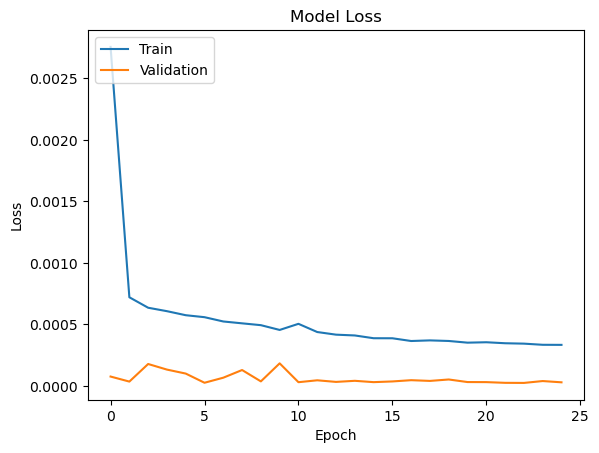

In [93]:
import matplotlib.pyplot as plt

plt.plot(history_e2d2_batch_128_24_in_Mor.history['loss'])
plt.plot(history_e2d2_batch_128_24_in_Mor.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [79]:
import pickle
with open('history_e2d2_batch_128_24_in_Mor.pkl', 'wb') as file:
    pickle.dump(history_e2d2_batch_128_24_in_Mor.history, file)

In [80]:
from keras.models import load_model
model_e2d2_batch_128_24_in_Mor.save('model_e2d2_batch_128_24_in_Mor.h5')

In [81]:
pred_e2d2_batch_128_24_in_Mor=model_e2d2_batch_128_24_in_Mor.predict(X_test)

436/436 [==============================] - 18s 39ms/step


In [82]:
for index,i in enumerate(train_merged.columns):
    scaler = scalers_Morpeth['scaler_'+i]
    pred_e2d2_batch_128_24_in_Mor[:,:,index]=scaler.inverse_transform(pred_e2d2_batch_128_24_in_Mor[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
    y_valid[:,:,index]=scaler.inverse_transform(y_valid[:,:,index])

In [83]:
def calculate_nse(y_true, y_pred):
    
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

for index, i in enumerate(train_merged.columns):
    print(i)
    for j in range(1, 49):
        print("time ", j, ":")
        mae = mean_absolute_error(y_test[:, j - 1, index], pred_e2d2_batch_128_24_in_Mor[:, j - 1, index])
        mse = mean_squared_error(y_test[:, j - 1, index], pred_e2d2_batch_128_24_in_Mor[:, j - 1, index])
        nse = calculate_nse(y_test[:, j - 1, index], pred_e2d2_batch_128_24_in_Mor[:, j - 1, index])
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("NSE: ", nse)
    print()

value_x
time  1 :
MAE:  0.04544100459113049
MSE:  0.014118611661518388
NSE:  0.238997419315914
time  2 :
MAE:  0.04437079045577943
MSE:  0.014710045178350199
NSE:  0.20711875848137773
time  3 :
MAE:  0.03915039641120408
MSE:  0.015429905502137973
NSE:  0.16831780713658673
time  4 :
MAE:  0.04370384645047058
MSE:  0.015934377646522814
NSE:  0.14112642224946859
time  5 :
MAE:  0.04828401820309486
MSE:  0.01635804733736649
NSE:  0.11829034347492207
time  6 :
MAE:  0.0502645381723575
MSE:  0.016709297420057778
NSE:  0.09935772985809399
time  7 :
MAE:  0.05044434032523062
MSE:  0.016977166448960194
NSE:  0.08491941062620456
time  8 :
MAE:  0.050229181288434496
MSE:  0.01715888635665803
NSE:  0.07512458645828379
time  9 :
MAE:  0.05038574657480533
MSE:  0.01727854848406497
NSE:  0.06867471801866754
time  10 :
MAE:  0.05112839728062737
MSE:  0.017394233919456457
NSE:  0.062439195929732905
time  11 :
MAE:  0.052238904399296515
MSE:  0.017486989598943126
NSE:  0.0574396029701183
time  12 :
MAE:

the best batch size and window size is 128 and 24,and the learning rate for the lowest val_loss value is 4.7830e-04.

In [84]:
n_past = 24
n_future = 48 
n_features = 2
X_train, y_train = split(train_Morpeth.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split(test_Morpeth.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split(valid_Morpeth.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

In [94]:
e_in = tf.keras.layers.Input(shape=(n_past, n_features))
e_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
e_outs1 = e_l1(e_in)
e_states1 = e_outs1[1:]
e_l2 = tf.keras.layers.LSTM(100, return_state=True)
e_outs2 = e_l2(e_outs1[0])
e_states2 = e_outs2[1:]

d_in = tf.keras.layers.RepeatVector(n_future)(e_outs2[0])

d_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(d_in,initial_state = e_states1)
d_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(d_l1,initial_state = e_states2)
d_outs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(d_l2)

model_e2d2_batch_128_24_in_Mor_100epoch= tf.keras.models.Model(e_in,d_outs2)

In [95]:
reduce_learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e2d2_batch_128_24_in_Mor_100epoch.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2_batch_128_24_in_Mor_100epoch=model_e2d2_batch_128_24_in_Mor_100epoch.fit(X_train,y_train,epochs=100,validation_data=(X_valid,y_valid),batch_size=128,verbose=1,callbacks=[reduce_learning_rate])

Epoch 1/100
876/876 [==============================] - 246s 274ms/step - loss: 0.0026 - val_loss: 1.8145e-04 - lr: 0.0010
Epoch 2/100
876/876 [==============================] - 246s 281ms/step - loss: 7.1081e-04 - val_loss: 8.6841e-05 - lr: 9.0000e-04
Epoch 3/100
876/876 [==============================] - 241s 276ms/step - loss: 6.2857e-04 - val_loss: 1.3246e-04 - lr: 8.1000e-04
Epoch 4/100
876/876 [==============================] - 242s 277ms/step - loss: 5.9892e-04 - val_loss: 6.4561e-05 - lr: 7.2900e-04
Epoch 5/100
876/876 [==============================] - 242s 276ms/step - loss: 5.5903e-04 - val_loss: 4.1166e-05 - lr: 6.5610e-04
Epoch 6/100
876/876 [==============================] - 242s 276ms/step - loss: 5.3715e-04 - val_loss: 1.9667e-04 - lr: 5.9049e-04
Epoch 7/100
876/876 [==============================] - 242s 276ms/step - loss: 5.1812e-04 - val_loss: 9.9867e-05 - lr: 5.3144e-04
Epoch 8/100
876/876 [==============================] - 257s 293ms/step - loss: 4.9079e-04 - val_lo

Epoch 64/100
876/876 [==============================] - 244s 279ms/step - loss: 2.8440e-04 - val_loss: 2.5208e-05 - lr: 1.3100e-06
Epoch 65/100
876/876 [==============================] - 250s 286ms/step - loss: 2.8431e-04 - val_loss: 2.4609e-05 - lr: 1.1790e-06
Epoch 66/100
876/876 [==============================] - 246s 281ms/step - loss: 2.8423e-04 - val_loss: 2.4713e-05 - lr: 1.0611e-06
Epoch 67/100
876/876 [==============================] - 244s 279ms/step - loss: 2.8418e-04 - val_loss: 2.4628e-05 - lr: 9.5500e-07
Epoch 68/100
876/876 [==============================] - 247s 282ms/step - loss: 2.8402e-04 - val_loss: 2.4860e-05 - lr: 8.5950e-07
Epoch 69/100
876/876 [==============================] - 247s 282ms/step - loss: 2.8413e-04 - val_loss: 2.4460e-05 - lr: 7.7355e-07
Epoch 70/100
876/876 [==============================] - 246s 281ms/step - loss: 2.8401e-04 - val_loss: 2.4017e-05 - lr: 6.9620e-07
Epoch 71/100
876/876 [==============================] - 245s 280ms/step - loss: 2.8

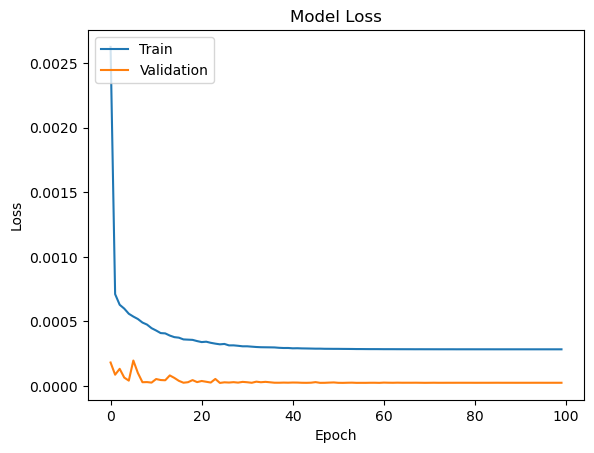

In [96]:
plt.plot(history_e2d2_batch_128_24_in_Mor_100epoch.history['loss'])
plt.plot(history_e2d2_batch_128_24_in_Mor_100epoch.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [97]:
pred_e2d2_batch_128_24_in_Mor_100epoch=model_e2d2_batch_128_24_in_Mor_100epoch.predict(X_test)

436/436 [==============================] - 22s 48ms/step


In [98]:
for index,i in enumerate(train_merged.columns):
    scaler = scalers_Morpeth['scaler_'+i]
    pred_e2d2_batch_128_24_in_Mor_100epoch[:,:,index]=scaler.inverse_transform(pred_e2d2_batch_128_24_in_Mor_100epoch[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
    y_valid[:,:,index]=scaler.inverse_transform(y_valid[:,:,index])

In [99]:
def calculate_nse(y_true, y_pred):
    
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

for index, i in enumerate(train_merged.columns):
    print(i)
    for j in range(1, 49):
        print("time ", j, ":")
        mae = mean_absolute_error(y_test[:, j - 1, index], pred_e2d2_batch_128_24_in_Mor_100epoch[:, j - 1, index])
        mse = mean_squared_error(y_test[:, j - 1, index], pred_e2d2_batch_128_24_in_Mor_100epoch[:, j - 1, index])
        nse = calculate_nse(y_test[:, j - 1, index], pred_e2d2_batch_128_24_in_Mor_100epoch[:, j - 1, index])
        print("MAE: ", mae)
        print("MSE: ", mse)
        print("NSE: ", nse)
    print()

value_x
time  1 :
MAE:  0.038711431948397934
MSE:  0.013069265601842201
NSE:  0.29555787147572465
time  2 :
MAE:  0.03801213759950313
MSE:  0.014026203839450989
NSE:  0.243978262528732
time  3 :
MAE:  0.04186932990193305
MSE:  0.014897068630123442
NSE:  0.19703806975220173
time  4 :
MAE:  0.03998105681140709
MSE:  0.015469758435073004
NSE:  0.16616970748355564
time  5 :
MAE:  0.04228309144870936
MSE:  0.015856506402078797
NSE:  0.14532373423762235
time  6 :
MAE:  0.04426117918065833
MSE:  0.016177475225903095
NSE:  0.12802330066063128
time  7 :
MAE:  0.04476405964598431
MSE:  0.016495696258506172
NSE:  0.11087097486227082
time  8 :
MAE:  0.044422478298105895
MSE:  0.01675188849552281
NSE:  0.09706204249732164
time  9 :
MAE:  0.04397486588632806
MSE:  0.01690979747643679
NSE:  0.08855064315653072
time  10 :
MAE:  0.04387285367122039
MSE:  0.017080008292130775
NSE:  0.0793761667201176
time  11 :
MAE:  0.04416304091655442
MSE:  0.017206857363777618
NSE:  0.07253891719481631
time  12 :
MAE